In [1]:
import os
import numpy as np
import pandas as pd
from pandas import read_csv, DataFrame
from matplotlib import pyplot as plt
import datetime as dt
from dataset.electricity_dataset import electricity_pre
from datetime import datetime
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import Sampler, SubsetRandomSampler
import random

In [2]:
warnings.filterwarnings('ignore')
now = datetime.now()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
np.set_printoptions(precision=4)

In [4]:
#for debugging
gc =0
GC=[]

In [5]:
agg_traffic = pd.read_csv('agg_traffic.csv')
agg_mat_max = agg_traffic.values
agg_mat_max = agg_mat_max[:,1:]
AG=agg_mat_max[:7].astype(int)

In [6]:
AG

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

In [7]:
data = pd.read_csv("trffc.csv", header=0) 
data.head()

Unnamed: 0      Total        y1        y2       y11       y12       y21  \
0  2008-01-01  1536.0182  757.3218  778.6964  360.5690  396.7528  410.6807   
1  2008-01-02  1619.2435  790.8156  828.4279  389.4334  401.3822  431.6908   
2  2008-01-03  1423.6574  684.3216  739.3358  329.0994  355.2222  387.1702   
3  2008-01-04  1096.3325  529.1279  567.2046  249.3346  279.7933  296.2565   
4  2008-01-05   974.5526  475.1733  499.3793  231.4860  243.6873  264.9305   

        y22  Bottom1  Bottom2  ...  Bottom191  Bottom192  Bottom193  \
0  368.0157   8.1370   2.1910  ...     5.5609     5.2466     9.3058   
1  396.7371   8.9488   8.1517  ...     5.3390     5.3748     9.7310   
2  352.1656   8.1359   4.7902  ...     5.1115     5.1326     9.6746   
3  270.9481   6.4700   1.5121  ...     2.9545     3.8832     6.7228   
4  234.4488   5.5741   1.4916  ...     2.5862     3.6739     5.5844   

   Bottom194  Bottom195  Bottom196  Bottom197  Bottom198  Bottom199  Bottom200  
0     8.7667     5.8731    11.3673     8.8627     8.1654     6.5542     8.5484  
1    12.0854     5.9546    11.8716     9.1413     8.2749     7.9835     7.4303  
2     8.9663     6.1468     9.7029     8.5609     7.8705     6.2287     6.7340  
3     6.5009     4.7770     7.6188     7.4227     5.5232     4.8793     5.8216  
4     5.7266     4.0254     6.4069     6.9933     5.1315     4.0133     5.2404  

[5 rows x 208 columns]

In [8]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
data

Total        y1        y2       y11       y12       y21       y22  \
0    1536.0182  757.3218  778.6964  360.5690  396.7528  410.6807  368.0157   
1    1619.2435  790.8156  828.4279  389.4334  401.3822  431.6908  396.7371   
2    1423.6574  684.3216  739.3358  329.0994  355.2222  387.1702  352.1656   
3    1096.3325  529.1279  567.2046  249.3346  279.7933  296.2565  270.9481   
4     974.5526  475.1733  499.3793  231.4860  243.6873  264.9305  234.4488   
..         ...       ...       ...       ...       ...       ...       ...   
361  1606.0017  801.1668  804.8349  423.0887  378.0781  408.4916  396.3433   
362  1567.3015  779.7629  787.5386  413.3880  366.3749  395.4527  392.0859   
363  1722.5124  878.3538  844.1586  428.7631  449.5907  429.9540  414.2046   
364  1776.7038  918.6770  858.0268  475.8637  442.8133  421.0122  437.0146   
365  1353.1695  707.7901  645.3794  356.5805  351.2096  321.7236  323.6558   

     Bottom1  Bottom2  Bottom3  ...  Bottom191  Bottom192  Bottom193  \
0     8.1370   2.1910   4.7163  ...     5.5609     5.2466     9.3058   
1     8.9488   8.1517   4.8137  ...     5.3390     5.3748     9.7310   
2     8.1359   4.7902   4.6435  ...     5.1115     5.1326     9.6746   
3     6.4700   1.5121   3.2586  ...     2.9545     3.8832     6.7228   
4     5.5741   1.4916   2.9172  ...     2.5862     3.6739     5.5844   
..       ...      ...      ...  ...        ...        ...        ...   
361   7.7495   9.0067   7.4960  ...    11.3703     7.0951     5.6765   
362   8.1097   9.2325   7.6123  ...    11.0934     7.4894     7.5004   
363   6.2941   5.9546  17.2047  ...    12.2824     7.6019     5.7080   
364   9.7905   9.3584   7.2440  ...    12.1320     7.1799     6.5667   
365   6.9438   7.0639   5.3488  ...     5.3459     5.5850     5.4051   

     Bottom194  Bottom195  Bottom196  Bottom197  Bottom198  Bottom199  \
0       8.7667     5.8731    11.3673     8.8627     8.1654     6.5542   
1      12.0854     5.9546    11.8716     9.1413     8.2749     7.9835   
2       8.9663     6.1468     9.7029     8.5609     7.8705     6.2287   
3       6.5009     4.7770     7.6188     7.4227     5.5232     4.8793   
4       5.7266     4.0254     6.4069     6.9933     5.1315     4.0133   
..         ...        ...        ...        ...        ...        ...   
361     6.8699     5.4110     8.9070     4.3274     2.6546    12.9457   
362     7.0521     5.5878     9.2178     4.4601     2.6299    13.1887   
363     6.9409     8.5787     7.2745    10.6823     2.8012    14.2313   
364     7.5545     2.8586    10.3623     8.6429     2.8779    14.2212   
365     6.1172     2.1928     9.3541     5.8936     1.7567    11.7125   

     Bottom200  
0       8.5484  
1       7.4303  
2       6.7340  
3       5.8216  
4       5.2404  
..         ...  
361    13.0458  
362    11.6035  
363    13.4012  
364    13.3731  
365    14.2597  

[366 rows x 207 columns]

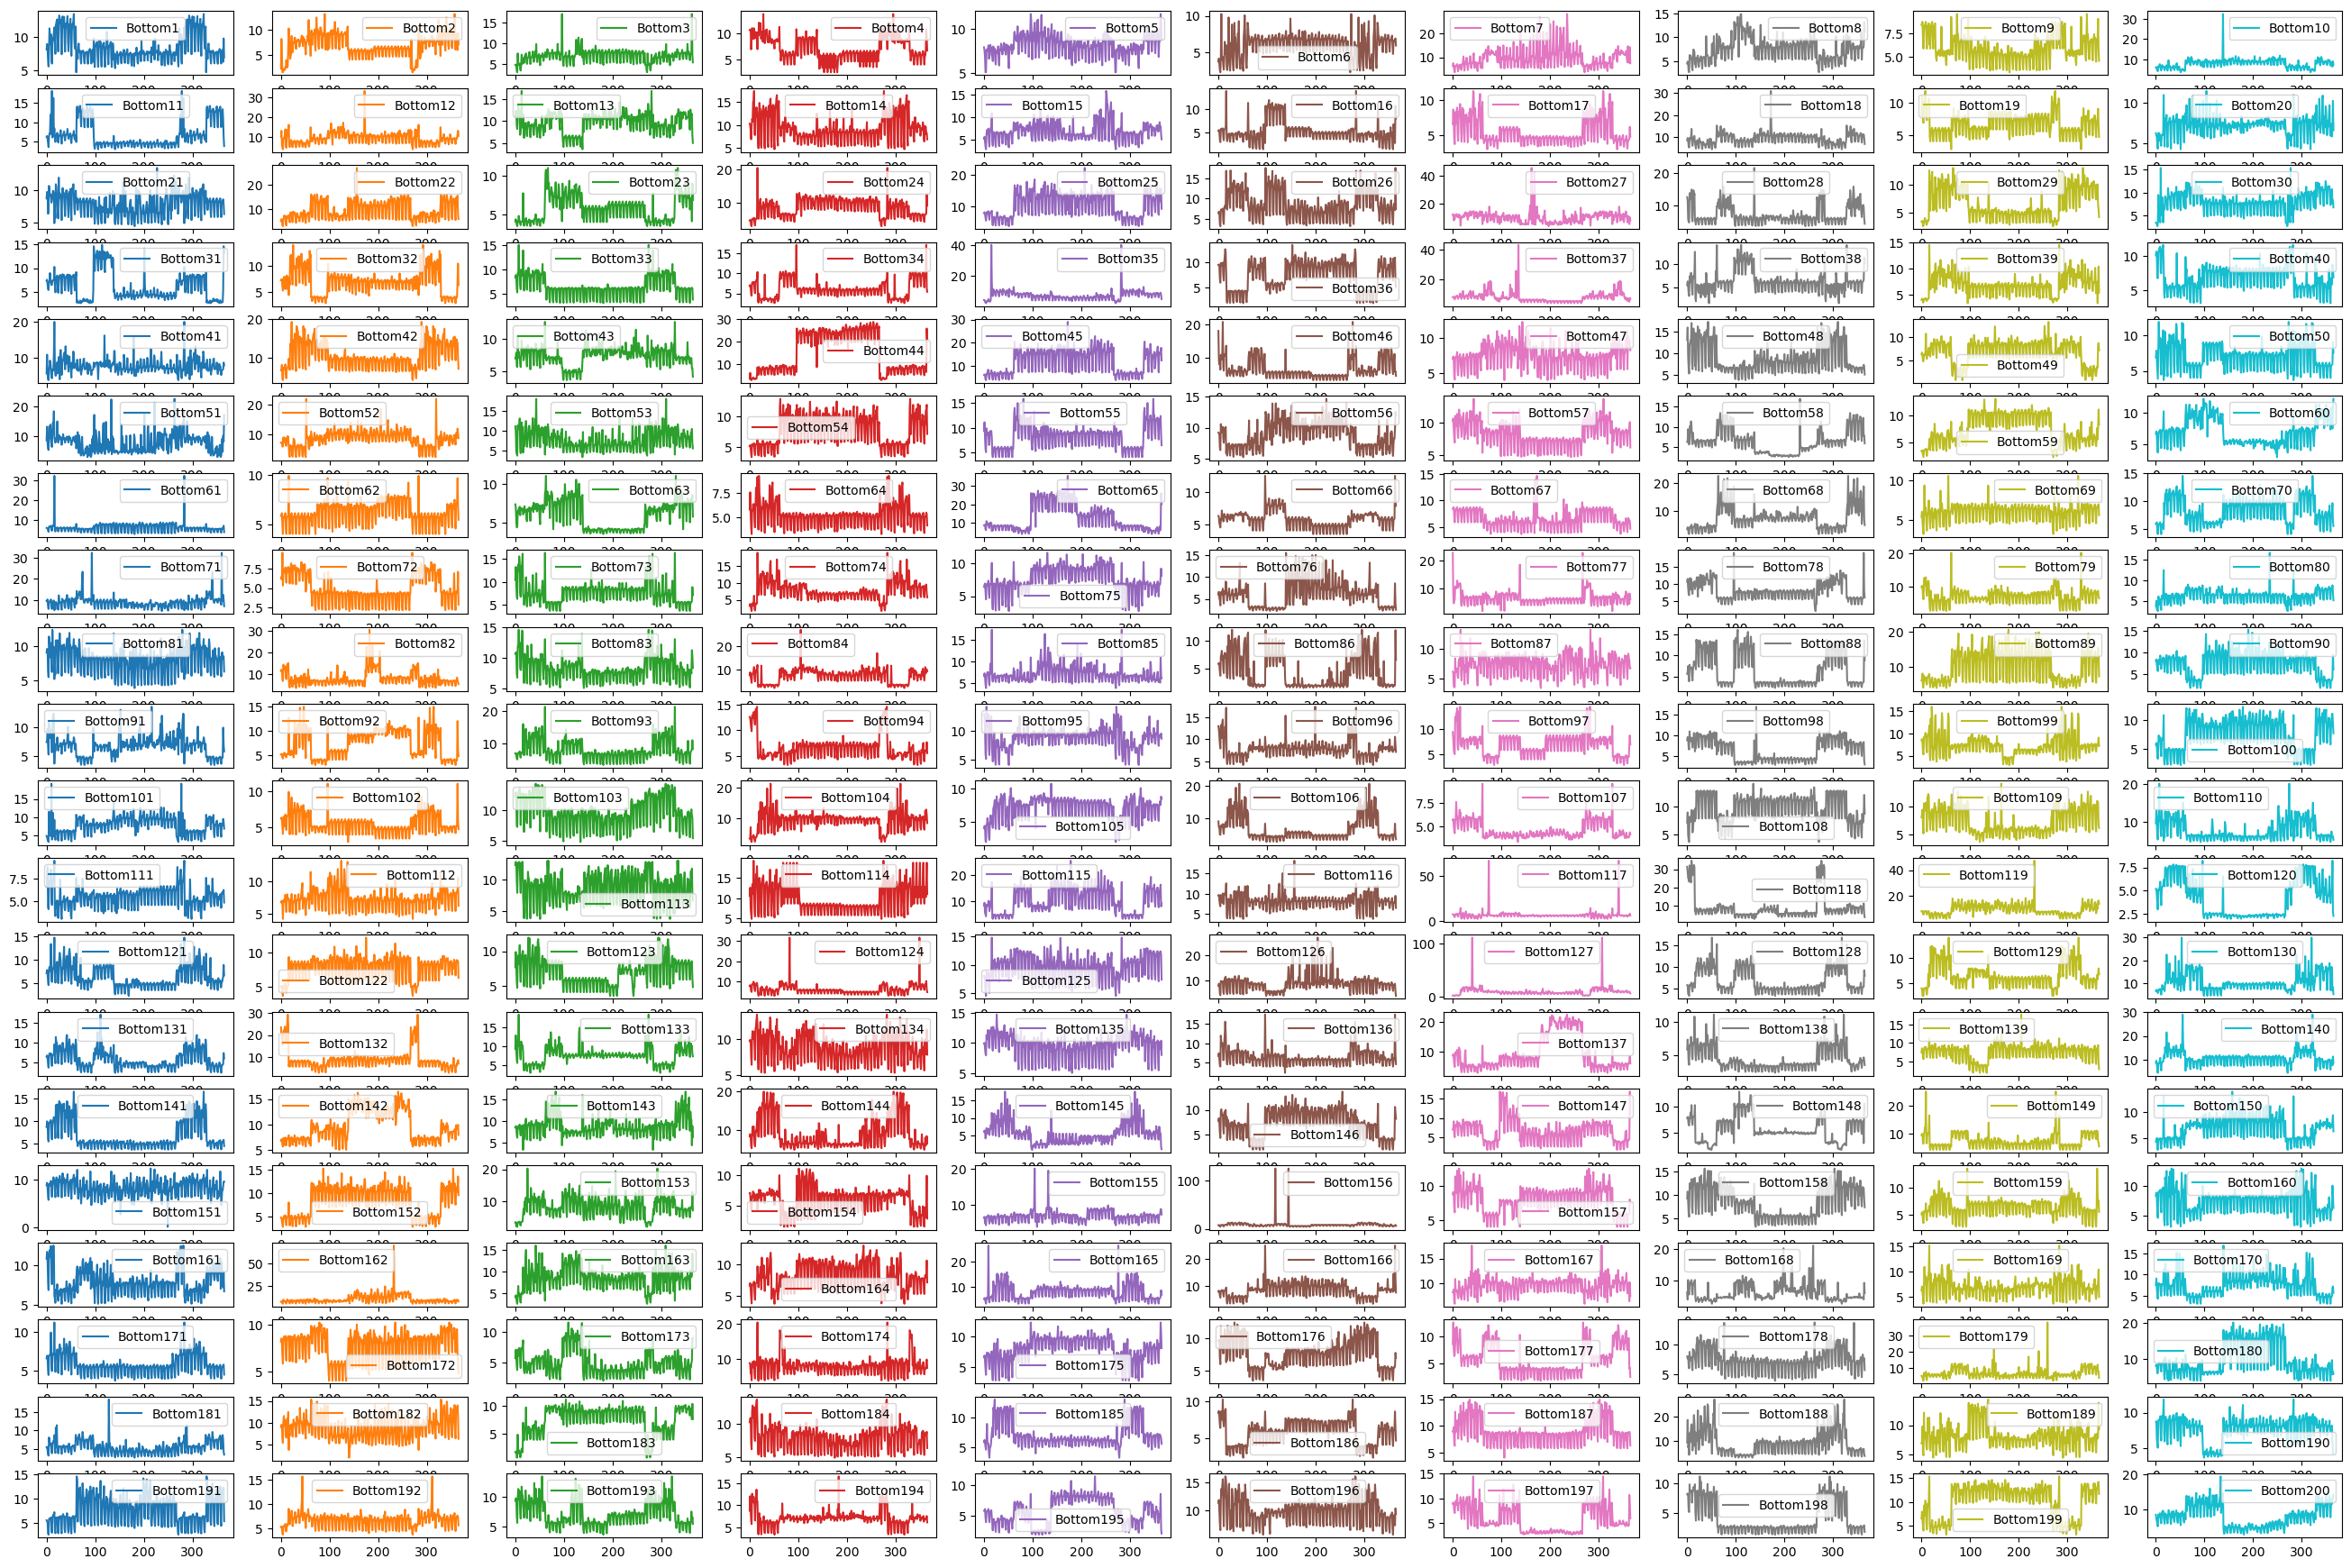

In [10]:
bottom=list(data.iloc[:,-200:].columns.values)
fig, axes = plt.subplots(nrows=20, ncols=10,figsize=(33,22))
data[data.columns.intersection(bottom)].plot(subplots=True, ax=axes)
plt.plot();

In [11]:
#  probabalistic model with likelihood function
class model(nn.Module):
    def __init__(self, num_lstms, input_dim, output_dim=1, hidden_dim=64):
        super(model, self).__init__()
        self.lstm_out = hidden_dim
        self.num_lstms = num_lstms
        lstms = []
        lstms.append(nn.LSTMCell(input_dim, self.lstm_out))
        for i in range(1, self.num_lstms):
            lstms.append(nn.LSTMCell(self.lstm_out, self.lstm_out))
        self.lstms = nn.ModuleList(lstms)
        # μ and σ  distibution -> next point for every t_i.prediction length is from output dimensions
        self.mean = nn.Linear(self.lstm_out, output_dim)
        self.std = nn.Linear(self.lstm_out, output_dim)
        
    def forward(self, input, covariates, future = 0):
        dev = input.device
        means = torch.Tensor().to(dev)
        stds = torch.Tensor().to(dev)
        outputs = []
        h_t = []
        c_t = []
        cond_ctx_len = input.size(1)
        pred_ctx_len = future
        #for covariartes concat input and covariates
        if covariates.shape[2] != 0:
            input = torch.cat((input, covariates[:, 0:cond_ctx_len, :]), 2)
        for i in range(0, self.num_lstms):
            h_t.append(torch.zeros(input.size(0), self.lstm_out, dtype=torch.float).to(dev))
            c_t.append(torch.zeros(input.size(0), self.lstm_out, dtype=torch.float).to(dev))
        '''
         h(hidden state),c(cell state)-> output of Lstm cell, h(i)-> passed to lstm(i+1) cell, 
         h(i) and c(i) are recurrent for lstm cell(i+1) 
         and the output from previous cell '''
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t[0], c_t[0] = self.lstms[0](input_t.squeeze(1), (h_t[0], c_t[0])) #first cell ->concat of input and covariates, recurrent input 
            for n in range(1, self.num_lstms):
                h_t[n], c_t[n] = self.lstms[n](h_t[n - 1], (h_t[n], c_t[n]))#susquent cells-> prev. output from stack, recurrent input
            mean = self.mean(h_t[n])
            std = self.std(h_t[n])
            means = torch.cat((means, mean.unsqueeze(1)), 1)
            stds = torch.cat((stds, std.unsqueeze(1)), 1)
        stds = self.softplus(stds)
       
        for i in range(future):
            output_t = torch.cat((mean, covariates[:, cond_ctx_len + i, :]), 1)
            h_t[0], c_t[0] = self.lstms[0](output_t, (h_t[0], c_t[0]))
            for n in range(1, self.num_lstms):
                h_t[n], c_t[n] = self.lstms[n](h_t[n - 1], (h_t[n], c_t[n]))
            mean = self.mean(h_t[n])
            std = self.std(h_t[n])
            std = self.softplus(std) # avoid infinties
            means = torch.cat((means, mean.unsqueeze(1)), 1)
            stds = torch.cat((stds, std.unsqueeze(1)), 1)
        means = means.unsqueeze(-1)
        stds = stds.unsqueeze(-1)
        outputs = torch.cat((means, stds), -1)
        return outputs

    def sample(self, mean, std):
        normal_dist = torch.distributions.normal.Normal(mean, std)
        return normal_dist.sample()

    def softplus(self, x):
        softplus = torch.log(1+torch.exp(x))
        softplus = torch.where(softplus==float('inf'), x, softplus)
        return softplus

    def NLL(self, outputs, truth,AG):#negative log liklihood
        hierarchy_tot,bottom_tot=AG.shape
        mean, std = torch.split(outputs, 1, dim=3)
        AG_tensor= torch.from_numpy(AG)    
        mean = mean.squeeze(3)
        std = std.squeeze(3)
        std=std**2
        #bottom value calculation
        bottom_mean= mean[:, :, -bottom_tot:]
        bottom_std=std[:, :, -bottom_tot:]
        #hierarchy value calculation
        Hierarchy_mean=torch.matmul(bottom_mean.float(),AG_tensor.T.float())
        Hierarchy_std=torch.matmul(bottom_std.float(),AG_tensor.T.float())
        #all values for loss calculation top values are hierarchy and lower values are bottom
        total_mean=torch.cat((Hierarchy_mean,bottom_mean),dim=2)
        total_std=torch.cat((Hierarchy_std,bottom_std),dim=2)**0.5
        torch.pi = torch.acos(torch.zeros(1)).item()
        loss = torch.mean((0.5*torch.log(2*torch.pi*(total_std**2)))+torch.div(torch.sub(total_mean,truth)**2, total_std**2))
        return loss
    


# using NLL
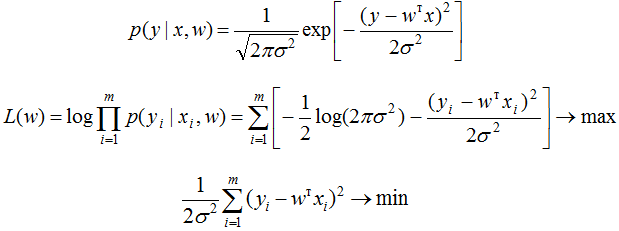!

In [12]:
def date_cv(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [13]:
'''

_params_ = {'lr': 0.01,
    'lr_step_size': 1000,
    'lr_gamma': .1,
    'ctx_win_len': 22,
    'cond_win_len': 10,
    'batch_size': 512,
    'num_covariates': 0,
    'total_num_covariates': 0,
    'num_time_idx': 0,
    'num_targets': 89,
    'total_num_targets': 89,
    'num_lstms': 2,
    'hidden_dim': 64,
    'max_batches_per_epoch': 200,
    'num_epochs': 100,
    'data_file': 'trsv.csv',
    'train_test_split':0.7
}

'''

_params_ = {'lr': 0.01,
    'lr_step_size': 1000,
    'lr_gamma': 1,
    'ctx_win_len':80,
    'cond_win_len':70,
    'batch_size': 512,
    'num_covariates': 0,
    'total_num_covariates': 0,
    'num_time_idx': 0,
    'num_targets': 207,
    'total_num_targets': 207,
    'num_lstms': 2,
    'hidden_dim': 128,
    'max_batches_per_epoch': 200,
    'num_epochs': 100,
    'data_file': 'trffc.csv',
    'train_test_split':0.7
}


In [14]:
class utils:
    def __init__(self, dev,_params):
        self.min = 0
        self.max = 0
        self.range = 0
        self.mean = 0
        self.dev = dev
        self._params = _params

    def split_batch(self, batch):
        num_time_idx = self._params['num_time_idx']
        num_targets = self._params['num_targets']
        total_num_targets = self._params['total_num_targets']
        num_covariates = self._params['num_covariates']    
        b = num_time_idx
        time_idx = batch[:, 1::, :b].to(self.dev).float()
        e = b + num_targets
        input = batch[:, 0:-1, b: e].to(self.dev).float()
        target = batch[:, 1::, b: e].to(self.dev).float()
        e = e - num_targets + total_num_targets
        total_num_covariates = batch.shape[2] - e + 1  
        covariates = time_idx
        b = e
        e = b + num_covariates
        if (num_covariates > 0):
            covariates = torch.cat((time_idx, batch[:, 1::, b: e]), -1)
        return input, target, covariates

    def scale(self, input, covariates):
        
        self.mean = torch.mean(input, dim=1).unsqueeze(1)
        input = input - self.mean
        min = torch.min(input, dim=1)[0].unsqueeze(1)
        max = torch.max(input, dim=1)[0].unsqueeze(1)
        self.range = max - min
        self.range[self.range < 1e-5] = 1e-5
        input = input / self.range

        num_covariates = self._params['num_covariates']
        if (num_covariates > 0):
            mean = torch.mean(covariates, dim=1).unsqueeze(1)
            covariates = covariates - mean
            min = torch.min(covariates, dim=1)[0].unsqueeze(1)
            max = torch.max(covariates, dim=1)[0].unsqueeze(1)
            range = max - min
            range[range < 1e-5] = 1e-5
            covariates = covariates / range
        return input, covariates

    def invert_scale(self, input, probabalistic=False):
        if probabalistic == False:
            return input * self.range + self.mean
        else:
            mean = input[:, :, :, 0]
            std = input[:, :, :, 1]
            scaled_mean = mean * self.range + self.mean
            scaled_std = std * torch.sqrt(self.range)
            return torch.cat((scaled_mean.unsqueeze(-1), scaled_std.unsqueeze(-1)), -1)

In [15]:
data.dtypes

Total        float64
y1           float64
y2           float64
y11          float64
y12          float64
              ...   
Bottom196    float64
Bottom197    float64
Bottom198    float64
Bottom199    float64
Bottom200    float64
Length: 207, dtype: object

In [16]:
data.to_csv('dataset/trffc.csv')

In [17]:
class MyDataset(Dataset):
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        rel_time = torch.from_numpy(np.arange(0, self.ctx_win_len) * self.resolution).unsqueeze(1).float().to(self.dev)
        abs_time = torch.from_numpy(np.arange(idx, idx + self.ctx_win_len) * self.resolution).unsqueeze(1).float().to(
            self.dev)
        if (self.num_time_indx == 2):  
            out = torch.cat((rel_time, abs_time, self.scaled[idx: idx + self.ctx_win_len, :]), -1).unsqueeze(0)
        if (self.num_time_indx == 1):  
            out = torch.cat((rel_time, self.scaled[idx: idx + self.ctx_win_len, :]), -1).unsqueeze(0)
        if (self.num_time_indx == 0):  
            out = self.scaled[idx: idx + self.ctx_win_len, :].unsqueeze(0)
        return torch.squeeze(out, 0)
    
    def get_train_test_samplers(self, train_test_split):
        indices = list(range(self.dataset_size))
        print
        split = int(np.floor(train_test_split * self.dataset_size))
        train_indices, test_indices = indices[: split - self.ctx_win_len], indices[split: -self.ctx_win_len]
        return SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)
    def plot_corr(self, df, size=10):
        corr = df.corr()
        fig, ax = plt.subplots(figsize=(size, size))
        ax.matshow(corr)
        plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
        plt.yticks(range(len(corr.columns)), corr.columns)


In [18]:
class Data_pre(MyDataset):
    def __init__(self, csv_file, dev, ctx_win_len, num_time_indx=1):
        self.num_time_indx = num_time_indx
        self.dev = dev
        df = read_csv('dataset/trffc.csv',index_col=0)
        self.ctx_win_len = ctx_win_len
        values = df.values
        values = values.astype('float32')
        self.scaled = values
        self.dataset_size = self.scaled.shape[0]
        self.scaled = torch.from_numpy(self.scaled).float().to(dev)
        self.resolution = 1

In [19]:
params = _params_
dataset_ = Data_pre(csv_file=params['data_file'], dev=device, ctx_win_len=params['ctx_win_len'], num_time_indx=params['num_time_idx'])

In [20]:
num_covariates = params['num_covariates']
num_time_idx = params['num_time_idx']
num_targets = params['num_targets']
input_dim = num_time_idx + num_targets + num_covariates
ctx_win_len = params['ctx_win_len']
cond_win_len = params['cond_win_len']
pred_win_len = ctx_win_len - cond_win_len - 1
batch_size = params['batch_size']

In [21]:
model = model(num_lstms=params['num_lstms'], input_dim=input_dim, output_dim=params['num_targets'],hidden_dim=params['hidden_dim']).to(device)
optimizer = optim.Adam(model.parameters(), params['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params['lr_step_size'], gamma=params['lr_gamma'])

In [22]:
train_sampler, test_sampler = dataset_.get_train_test_samplers(params['train_test_split'])

In [23]:
train_dataloader = DataLoader(dataset_, batch_size=batch_size, sampler=train_sampler, shuffle=False, num_workers=0)
test_dataloader = DataLoader(dataset_, batch_size=1, sampler=test_sampler,shuffle=False, num_workers=0)
max_batches_per_epoch = params['max_batches_per_epoch']
num_epochs = params['num_epochs']

In [24]:
def test_plot(out,target,AG,epoch):
    for v in range(out.shape[0]):
        preds = out[0, :, :, :].detach().cpu().numpy()
        targets = target[0, :, :].detach().cpu().numpy()
        preds[:,0:7, 0]=preds[:,7:207, 0]@AG.T
        preds[:,0:7, 1]=((preds[:,7:207, 1])**2@AG.T)**0.5    
    for j in range(7):
        pred = preds[:, j, 0]  
        std = preds[:, j, 1]  
        targe = targets[:, j]
        plt.figure()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xticks()
        plt.yticks()
        plt.plot(np.arange(len(targe)), targe, 'r', linewidth=2.0)
        plt.plot(np.arange(cond_win_len), pred[0:cond_win_len], 'b', linewidth=2.0)
        plt.plot(np.arange(cond_win_len, cond_win_len + pred_win_len), pred[cond_win_len:], 'g' + ':',
                 linewidth=2.0)
        plt.fill_between(np.arange(len(targe)), pred - std, pred + std, color='cyan', alpha=0.5)
        plt.fill_between(np.arange(len(targe)), pred - 2 * std, pred + 2 * std, color='cyan', alpha=0.2)
        plt.title(j)
        text='figures/'+str(epoch)+str(f"{j:02d}")
        plt.savefig(text)   # save the figure to file
        plt.close()

In [25]:
losses = []
batch_num = 1
utils = utils(device, params)
# Trainin loop
def train():
    for epoch in range(0, num_epochs):
        for i, batch in enumerate(train_dataloader):
            input, target, covariates = utils.split_batch(batch) 
            #splitting batches : issue with sequence
            #conditioning window input,Prediction window , model op conditioned on previous values
            # model output for the previous step
            input_cond = input[:, 0:cond_win_len, :]
            input_cond, covariates = utils.scale(input_cond, covariates)
            optimizer.zero_grad()
            #forward pass
            out = model(input_cond, covariates, future=pred_win_len)
            out = utils.invert_scale(out, probabalistic=True)
            #rescale
            test_plot(out,target,AG,epoch)
            loss = model.NLL(out, target,AG)
            #loss calc
            loss.backward()
            scheduler.step()
            optimizer.step()
            loss = loss.item()
            losses.append(loss)
            print(f"epoch:{epoch} /{num_epochs}|:loss:{loss}")
    return model, losses


In [26]:
model, losses = train()
data='traffic'#  dataset
date_=str(now).replace(" ", "")
model_save_ = f"{data}_epochs{params['num_epochs']}_{ date_ }"
torch.save(model.state_dict(), model_save_+".pth")

epoch:0 /100|:loss:3.1633450984954834
epoch:1 /100|:loss:2.943232774734497
epoch:2 /100|:loss:2.558478593826294
epoch:3 /100|:loss:3.2530438899993896
epoch:4 /100|:loss:2.2812857627868652
epoch:5 /100|:loss:2.243436813354492
epoch:6 /100|:loss:2.216949462890625
epoch:7 /100|:loss:2.163652181625366
epoch:8 /100|:loss:2.1166460514068604
epoch:9 /100|:loss:2.055826187133789
epoch:10 /100|:loss:1.9996793270111084
epoch:11 /100|:loss:1.9364502429962158
epoch:12 /100|:loss:1.8998849391937256
epoch:13 /100|:loss:1.9396635293960571
epoch:14 /100|:loss:1.9737706184387207
epoch:15 /100|:loss:1.8260672092437744
epoch:16 /100|:loss:1.8507087230682373
epoch:17 /100|:loss:1.7837132215499878
epoch:18 /100|:loss:1.775173306465149
epoch:19 /100|:loss:1.7343904972076416
epoch:20 /100|:loss:1.7077252864837646
epoch:21 /100|:loss:1.677943468093872
epoch:22 /100|:loss:1.6453016996383667
epoch:23 /100|:loss:1.6300235986709595
epoch:24 /100|:loss:1.6024786233901978
epoch:25 /100|:loss:1.5859144926071167
epoc

loss (prediction): 1.4030957221984863


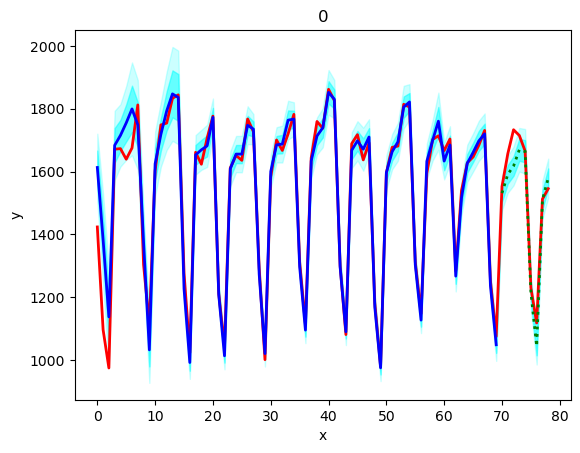

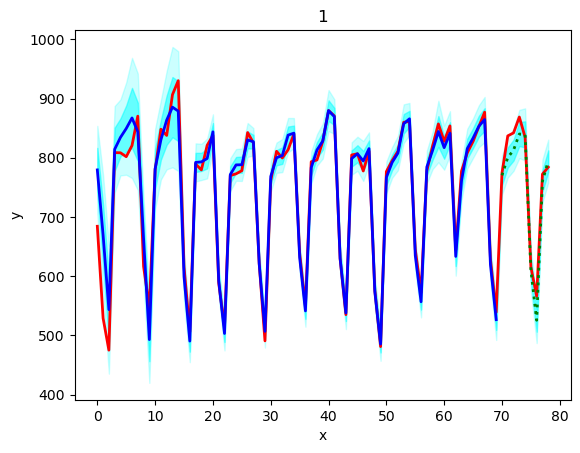

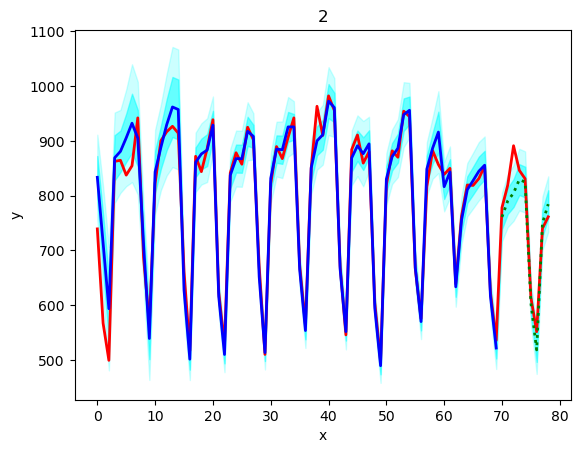

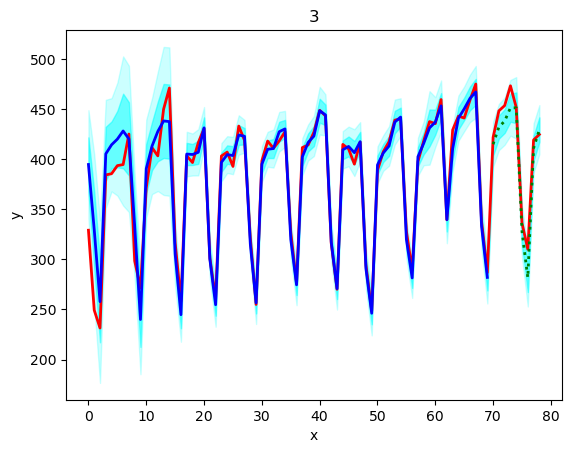

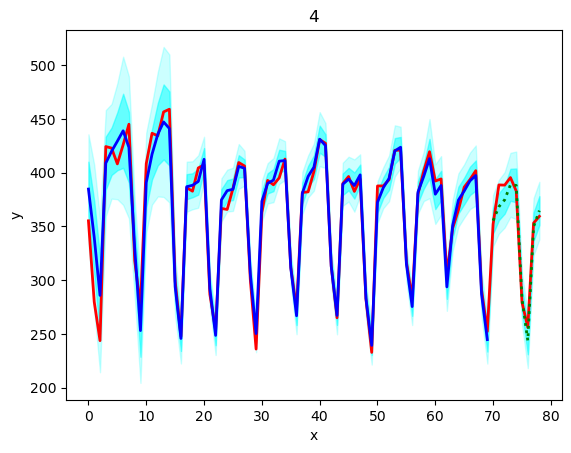

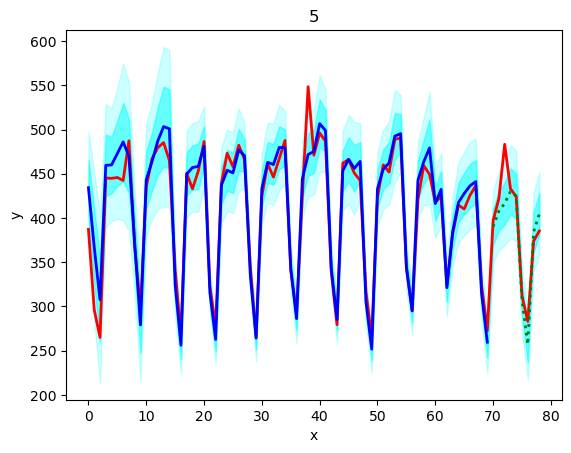

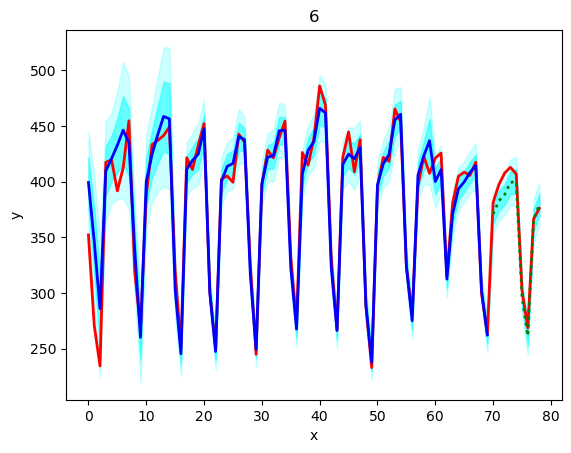

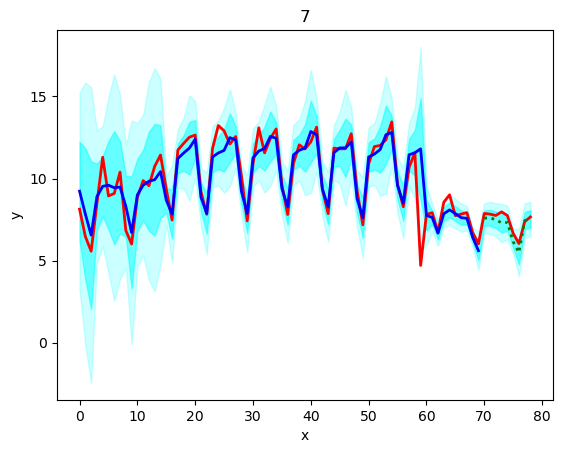

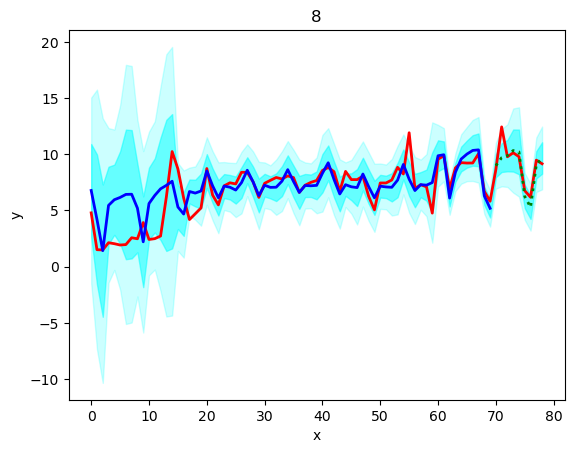

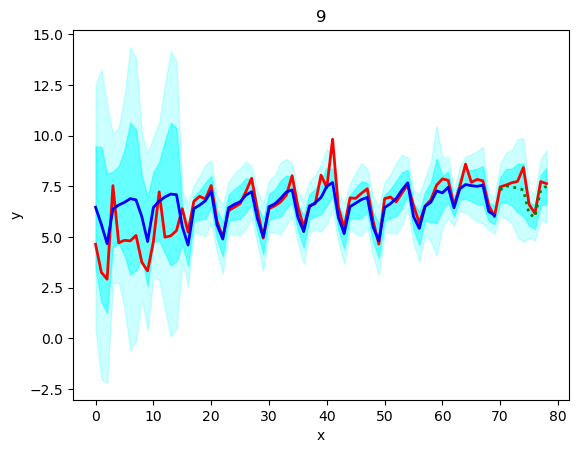

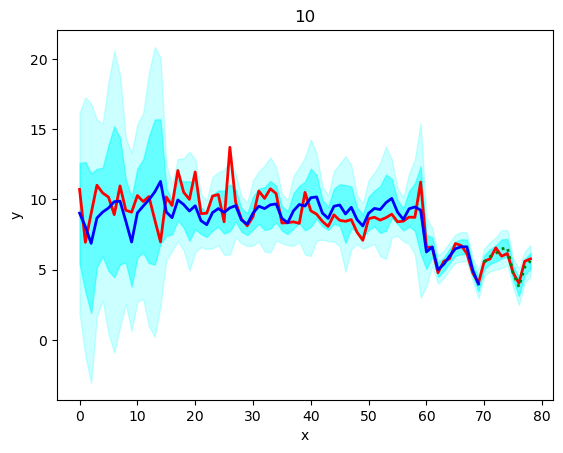

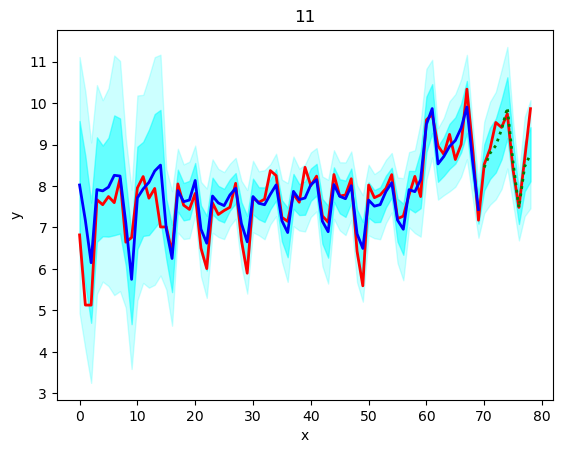

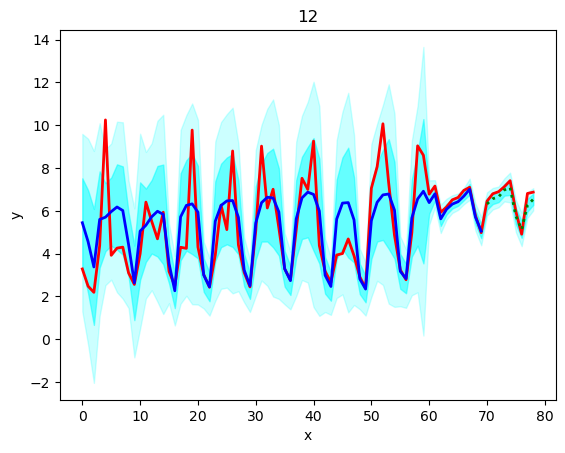

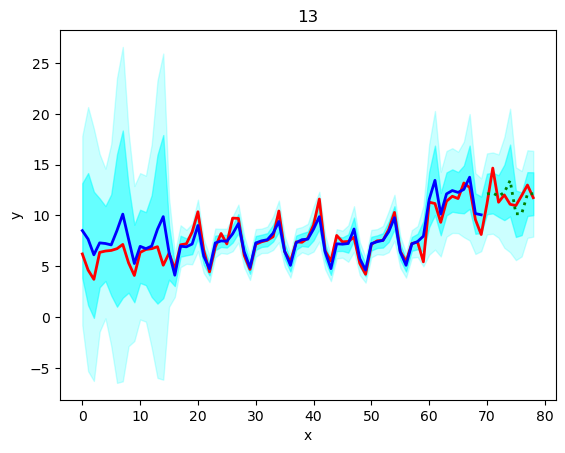

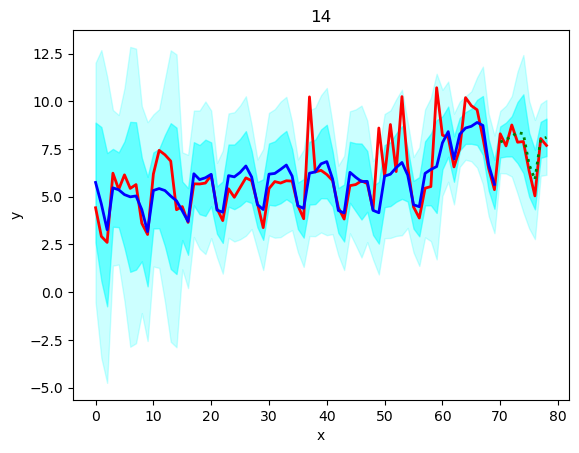

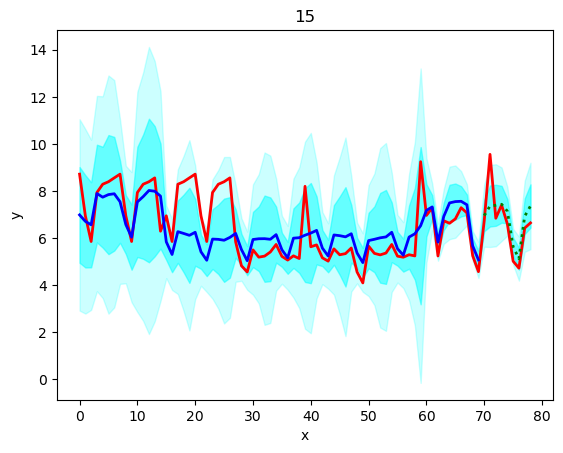

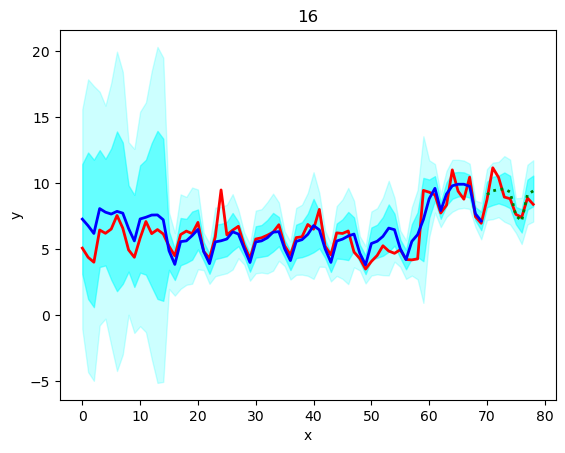

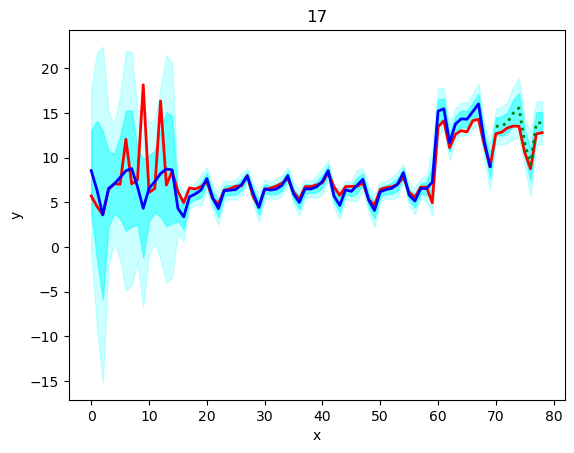

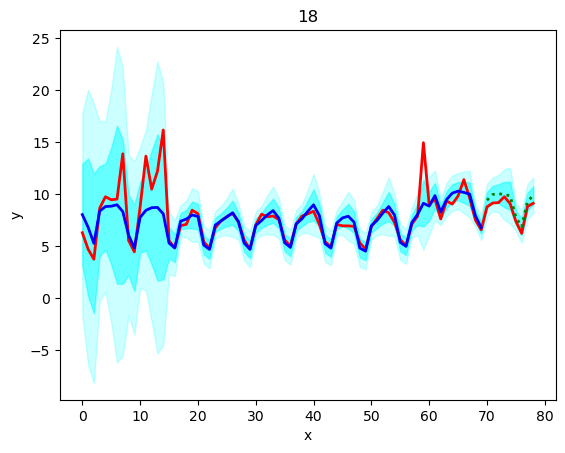

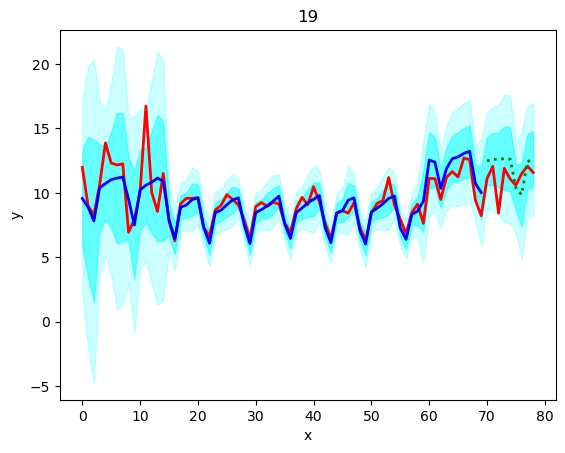

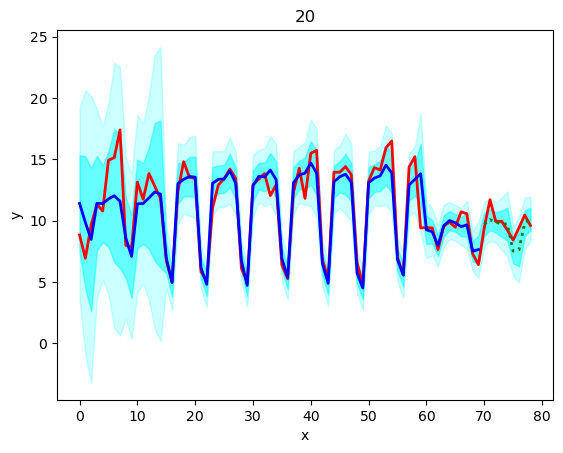

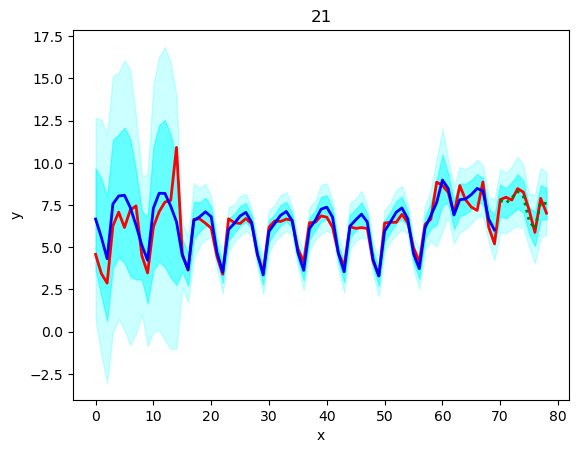

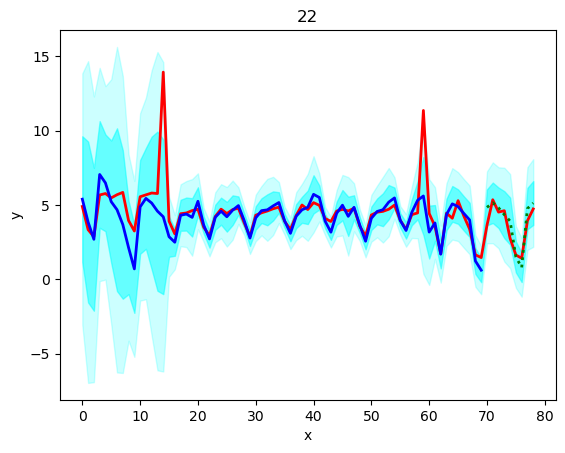

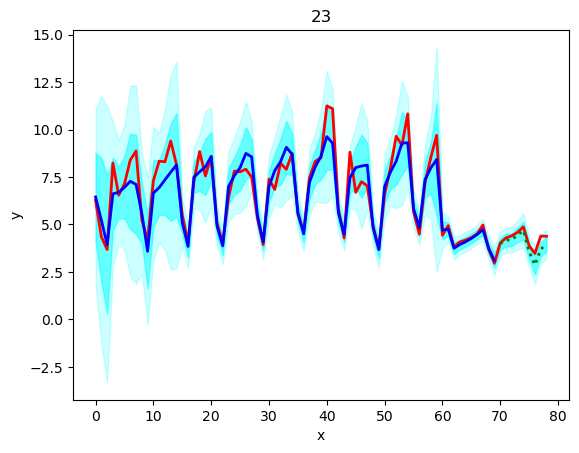

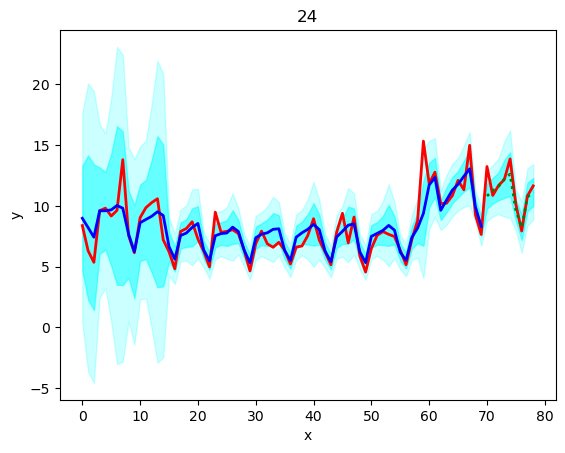

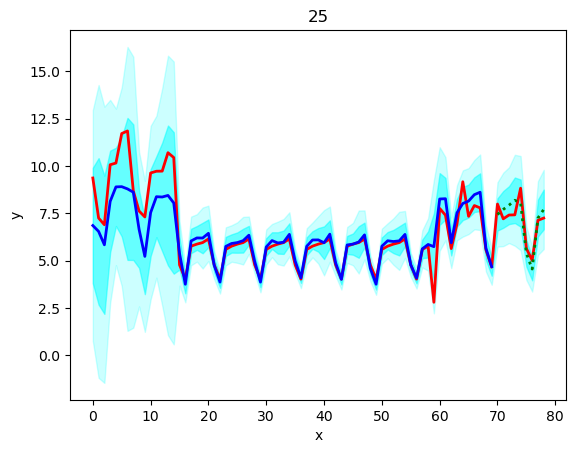

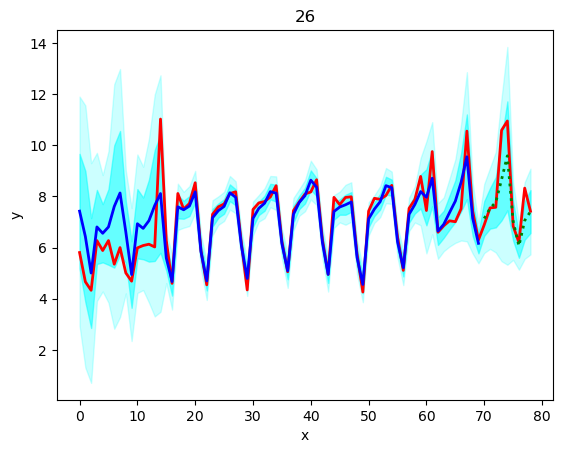

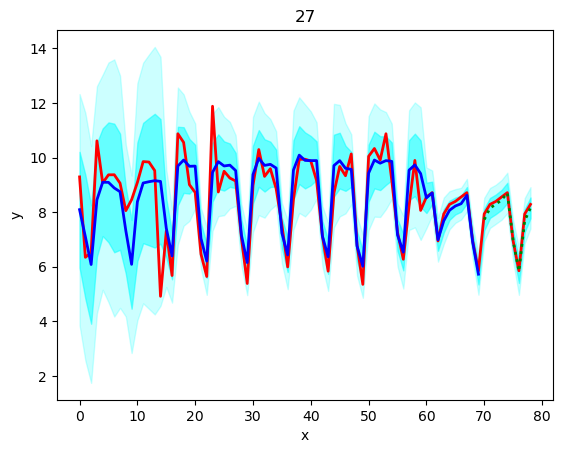

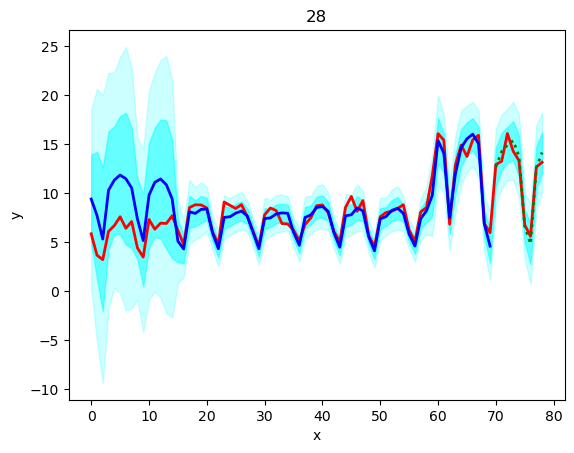

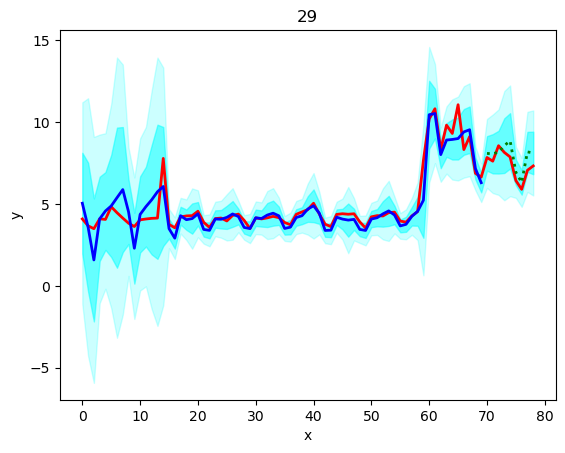

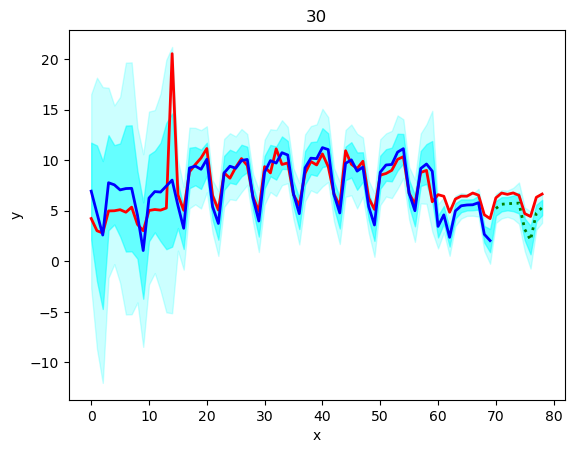

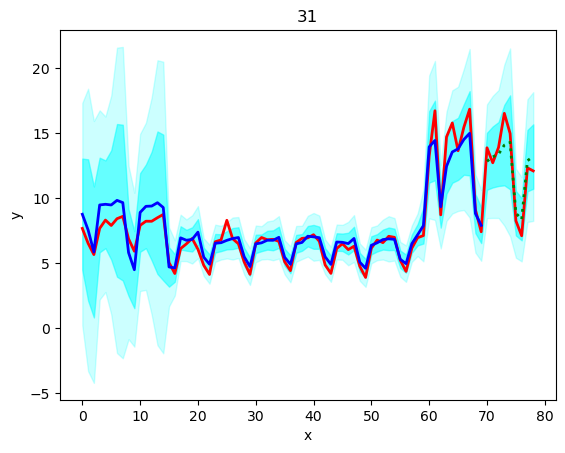

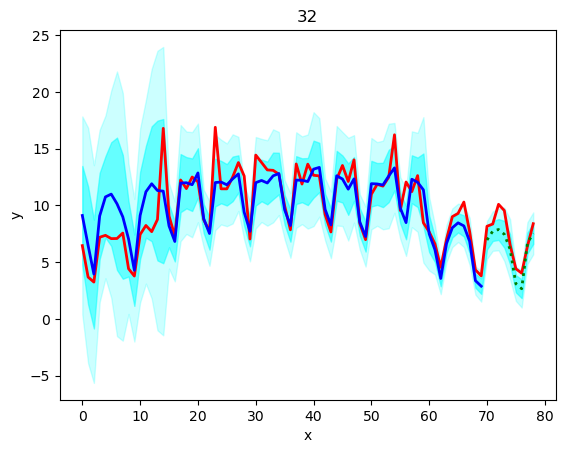

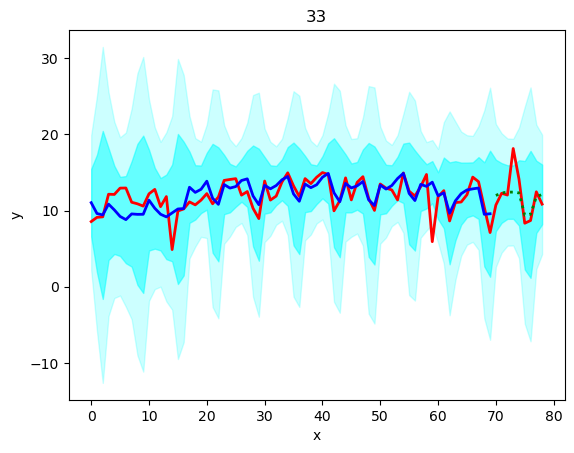

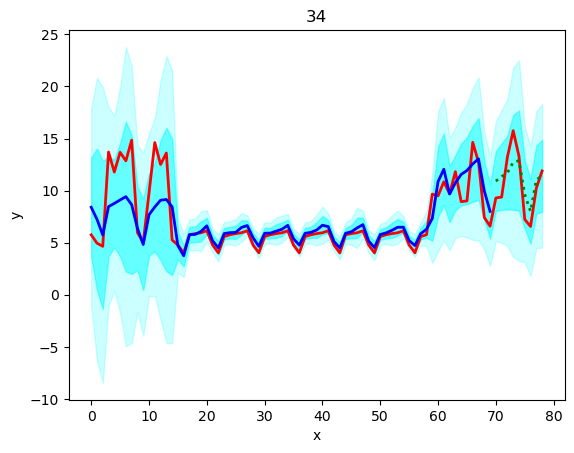

In [ ]:
test_dataloader_iter = iter(test_dataloader)
for i in range(0, 1):
    test_batch = next(test_dataloader_iter)
    with torch.no_grad():
        input, target, covariates = utils.split_batch(test_batch)
        input, covariates = utils.scale(input, covariates)
        pred = model(input[:, 0:cond_win_len, :], covariates, future=pred_win_len)
        pred = utils.invert_scale(pred, True)
        loss = model.NLL(pred, target,AG)
        print("loss (prediction): {0}".format(loss))
        preds = pred[0, :, :, :].detach().cpu().numpy()
        targets = target[0, :, :].detach().cpu().numpy()
        preds[:,0:7, 0]=preds[:,7:207, 0]@AG.T
        preds[:,0:7, 1]=((preds[:,7:207, 1])**2@AG.T)**0.5    
    for j in range(num_targets):
        pred = preds[:, j, 0]  
        std = preds[:, j, 1]  
        target = targets[:, j]
        plt.figure()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xticks()
        plt.yticks()
        plt.plot(np.arange(len(target)), target, 'r', linewidth=2.0)
        plt.plot(np.arange(cond_win_len), pred[0:cond_win_len], 'b', linewidth=2.0)
        plt.plot(np.arange(cond_win_len, cond_win_len + pred_win_len), pred[cond_win_len:], 'g' + ':',
                 linewidth=2.0)
        plt.fill_between(np.arange(len(target)), pred - std, pred + std, color='cyan', alpha=0.5)
        plt.fill_between(np.arange(len(target)), pred - 2 * std, pred + 2 * std, color='cyan', alpha=0.2)
        plt.title(j)